In [159]:
import os
def is_running_on_kaggle():
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ and os.environ["KAGGLE_KERNEL_RUN_TYPE"] == "Interactive"
DATA_PATH = '/kaggle/input/aerial-cactus/' if is_running_on_kaggle() else 'data/'
print('Running on Kaggle' if is_running_on_kaggle() else 'Running locally')

Running locally


In [160]:
import torch
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
import pandas as pd

In [161]:
# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [162]:
ANNOTATIONS_FILE = DATA_PATH + 'train.csv'
IMG_DIR = DATA_PATH + 'train/train/'
CHECKPOINT_DIR = '/kaggle/working/checkpoints' if is_running_on_kaggle() else 'checkpoints/'
FIGURES_DIR = '/kaggle/working/figures' if is_running_on_kaggle() else 'figures/'

SEED = 42
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
TRAIN_SPLIT = 0.8
EPOCHS = 100 if is_running_on_kaggle() else 100

In [163]:
torch.manual_seed(42)

In [164]:
from torchvision.io import read_image

class CactusDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [165]:
import torchvision.transforms as transforms

# mean and std of the cactai dataset
mean = [0.5035902857780457, 0.451941579580307, 0.4681771695613861]
std = [0.15118408203125, 0.1397838294506073, 0.15320344269275665]

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=mean, std=std),
])

In [166]:
# Create the dataset object
trainval_data = CactusDataset(ANNOTATIONS_FILE, IMG_DIR, transform=transform)

# Print the shape of the first image in the dataset
print(trainval_data[0][0].shape)

torch.Size([3, 32, 32])


In [167]:
from torch.utils.data import random_split

# Define the sizes of training and validation sets
train_size = int(TRAIN_SPLIT * len(trainval_data))
val_size = len(trainval_data) - train_size

# Split the dataset into training and validation sets
train_data, val_data = random_split(trainval_data, [train_size, val_size])

# Print the sizes of the training and validation sets
print("Training set size:", len(train_data))
print("Validation set size:", len(val_data))

Training set size: 14000
Validation set size: 3500


In [168]:
# Utility function for saving epochs checkpoints
def save_checkpoint(model, optimizer, loss, dir, desc):
    checkpoint_dir = os.path.join(CHECKPOINT_DIR, dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{desc}.pt')
    torch.save({
        'desc': desc,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, checkpoint_path)

# Utility function for loading epochs checkpoints
def load_checkpoint(model, optimizer, dir, desc):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, dir, f'checkpoint_{desc}.pt')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    return model, optimizer, loss

In [169]:
# Training loop (1 epoch)
def train_model(train_dataloader, model, criterion, optimizer, checkpoint=False, desc='Training', dir_checkpoint=None):
    avg_train_loss = 0
    train_bar = tqdm(train_dataloader, desc=desc, leave=False)
    
    model.train()
    for X, y in train_bar:
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X.float())
        y = y.reshape(-1, 1).float()
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the average loss
        avg_train_loss += loss.item() * len(y)

        # Update the loading bar
        train_bar.set_postfix({'loss': loss.item()})
        
    avg_train_loss = avg_train_loss / len(train_dataloader.dataset)
    train_bar.set_postfix({'loss': avg_train_loss})
    train_bar.close()

    if checkpoint:
        save_checkpoint(model, optimizer, avg_train_loss, dir_checkpoint, desc)

    return avg_train_loss

In [170]:
# Compute validation loss and error rate
def evaluate(val_dataloader, model, criterion, desc='Validation'):
    avg_val_loss = 0
    errors = []
    val_bar = tqdm(val_dataloader, desc=desc, leave=False)

    model.eval()
    with torch.no_grad():
        for X, y in val_bar:
            X = X.to(device)
            y = y.to(device)

            # Compute prediction and loss
            pred = model(X.float())
            y = y.reshape(-1, 1).float()
            loss = criterion(pred, y)

            # Save errors for error rate
            pred = nn.Sigmoid()(pred) > 0.5
            errors += pred != y

            # Update the average loss
            avg_val_loss += loss.item() * len(y)

            # Update the loading bar
            val_bar.set_postfix({'loss': loss.item()})
    
    avg_val_loss = avg_val_loss / len(val_dataloader.dataset)
    val_bar.set_postfix({'loss': avg_val_loss})
    val_bar.close()
    return avg_val_loss, errors

In [171]:
# Early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [172]:
class CustomConvNet(torch.nn.Module):
    def __init__(self, fc_size, dropout):
        super(CustomConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128, fc_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(fc_size, 1)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

>>>>>>>>     FC Size: 6 - Dropout: 0.1     <<<<<<<<


TrainingEpoch01:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/100	 Train Loss: 0.2416 - Val Loss: 0.0847 - Error Rate: 0.0271


Epoch 2/100	 Train Loss: 0.0973 - Val Loss: 0.0608 - Error Rate: 0.0211


Epoch 3/100	 Train Loss: 0.0807 - Val Loss: 0.0533 - Error Rate: 0.0177


Epoch 4/100	 Train Loss: 0.0599 - Val Loss: 0.0375 - Error Rate: 0.0114


Epoch 5/100	 Train Loss: 0.0470 - Val Loss: 0.0320 - Error Rate: 0.0100


Epoch 6/100	 Train Loss: 0.0465 - Val Loss: 0.0417 - Error Rate: 0.0154


Epoch 7/100	 Train Loss: 0.0372 - Val Loss: 0.0263 - Error Rate: 0.0083


Epoch 8/100	 Train Loss: 0.0285 - Val Loss: 0.0281 - Error Rate: 0.0086


Epoch 9/100	 Train Loss: 0.0251 - Val Loss: 0.0299 - Error Rate: 0.0089


Epoch 10/100	 Train Loss: 0.0256 - Val Loss: 0.0348 - Error Rate: 0.0097


Epoch 11/100	 Train Loss: 0.0236 - Val Loss: 0.0324 - Error Rate: 0.0094


Epoch 12/100	 Train Loss: 0.0190 - Val Loss: 0.0237 - Error Rate: 0.0083


Epoch 13/100	 Train Loss: 0.0163 - Val Loss: 0.0362 - Error Rate: 0.0100


Epoch 14/100	 Train Loss: 0.0162 - Val Loss: 0.0417 - Error Rate: 0.0120


Epoch 15/100	 Train Loss: 0.0147 - Val Loss: 0.0302 - Error Rate: 0.0086


Epoch 16/100	 Train Loss: 0.0166 - Val Loss: 0.0241 - Error Rate: 0.0074


Epoch 17/100	 Train Loss: 0.0062 - Val Loss: 0.0377 - Error Rate: 0.0083


Epoch 18/100	 Train Loss: 0.0082 - Val Loss: 0.0448 - Error Rate: 0.0114


Epoch 19/100	 Train Loss: 0.0085 - Val Loss: 0.0989 - Error Rate: 0.0200


Epoch 20/100	 Train Loss: 0.0195 - Val Loss: 0.0349 - Error Rate: 0.0083


Epoch 21/100	 Train Loss: 0.0104 - Val Loss: 0.0440 - Error Rate: 0.0094


Epoch 22/100	 Train Loss: 0.0052 - Val Loss: 0.0444 - Error Rate: 0.0086


Epoch 23/100	 Train Loss: 0.0047 - Val Loss: 0.0413 - Error Rate: 0.0077
Early stopping on epoch 23


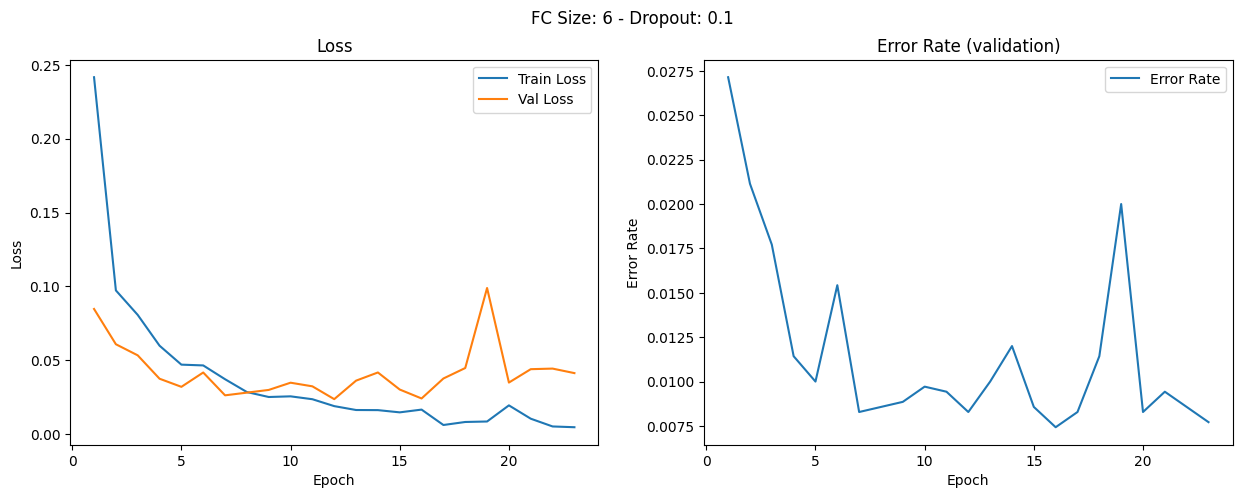

>>>>>>>>     FC Size: 6 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3486 - Val Loss: 0.1249 - Error Rate: 0.0420


Epoch 2/100	 Train Loss: 0.2324 - Val Loss: 0.1198 - Error Rate: 0.0231


Epoch 3/100	 Train Loss: 0.2030 - Val Loss: 0.0865 - Error Rate: 0.0237


Epoch 4/100	 Train Loss: 0.1741 - Val Loss: 0.0547 - Error Rate: 0.0151


Epoch 5/100	 Train Loss: 0.1588 - Val Loss: 0.0646 - Error Rate: 0.0191


Epoch 6/100	 Train Loss: 0.1418 - Val Loss: 0.0360 - Error Rate: 0.0120


Epoch 7/100	 Train Loss: 0.1314 - Val Loss: 0.0316 - Error Rate: 0.0117


Epoch 8/100	 Train Loss: 0.1195 - Val Loss: 0.0286 - Error Rate: 0.0091


Epoch 9/100	 Train Loss: 0.1139 - Val Loss: 0.0288 - Error Rate: 0.0086


Epoch 10/100	 Train Loss: 0.1114 - Val Loss: 0.0261 - Error Rate: 0.0077


Epoch 11/100	 Train Loss: 0.1027 - Val Loss: 0.0244 - Error Rate: 0.0074


Epoch 12/100	 Train Loss: 0.0927 - Val Loss: 0.0500 - Error Rate: 0.0131


Epoch 13/100	 Train Loss: 0.0839 - Val Loss: 0.0263 - Error Rate: 0.0089


Epoch 14/100	 Train Loss: 0.0910 - Val Loss: 0.0302 - Error Rate: 0.0097


Epoch 15/100	 Train Loss: 0.0921 - Val Loss: 0.0247 - Error Rate: 0.0089


Epoch 16/100	 Train Loss: 0.0840 - Val Loss: 0.0259 - Error Rate: 0.0071


Epoch 17/100	 Train Loss: 0.0881 - Val Loss: 0.0233 - Error Rate: 0.0069


Epoch 18/100	 Train Loss: 0.0838 - Val Loss: 0.0277 - Error Rate: 0.0077


Epoch 19/100	 Train Loss: 0.0824 - Val Loss: 0.0348 - Error Rate: 0.0097


Epoch 20/100	 Train Loss: 0.0861 - Val Loss: 0.0274 - Error Rate: 0.0077


Epoch 21/100	 Train Loss: 0.0883 - Val Loss: 0.0455 - Error Rate: 0.0103


Epoch 22/100	 Train Loss: 0.0791 - Val Loss: 0.0243 - Error Rate: 0.0071


Epoch 23/100	 Train Loss: 0.0809 - Val Loss: 0.0270 - Error Rate: 0.0060


Epoch 24/100	 Train Loss: 0.0783 - Val Loss: 0.0233 - Error Rate: 0.0083


Epoch 25/100	 Train Loss: 0.0912 - Val Loss: 0.0266 - Error Rate: 0.0080


Epoch 26/100	 Train Loss: 0.0823 - Val Loss: 0.0547 - Error Rate: 0.0114


Epoch 27/100	 Train Loss: 0.0840 - Val Loss: 0.0385 - Error Rate: 0.0134


Epoch 28/100	 Train Loss: 0.0873 - Val Loss: 0.0285 - Error Rate: 0.0094
Early stopping on epoch 28


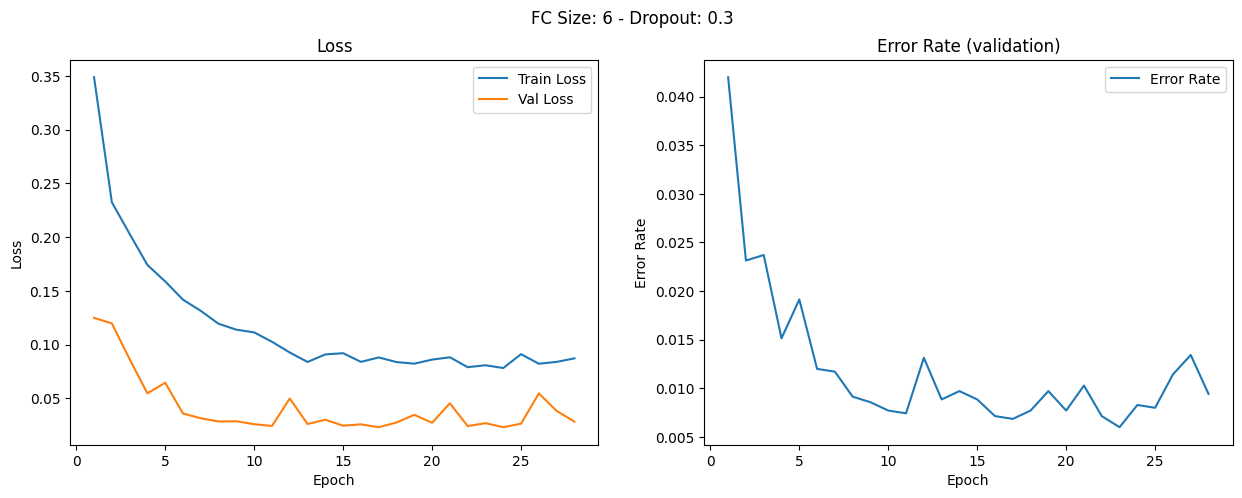

>>>>>>>>     FC Size: 6 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.3086 - Val Loss: 0.1942 - Error Rate: 0.0406


Epoch 2/100	 Train Loss: 0.2350 - Val Loss: 0.1613 - Error Rate: 0.0223


Epoch 3/100	 Train Loss: 0.2158 - Val Loss: 0.1462 - Error Rate: 0.0237


Epoch 4/100	 Train Loss: 0.1977 - Val Loss: 0.1297 - Error Rate: 0.0169


Epoch 5/100	 Train Loss: 0.1834 - Val Loss: 0.1146 - Error Rate: 0.0137


Epoch 6/100	 Train Loss: 0.1749 - Val Loss: 0.1061 - Error Rate: 0.0114


Epoch 7/100	 Train Loss: 0.1638 - Val Loss: 0.0988 - Error Rate: 0.0131


Epoch 8/100	 Train Loss: 0.1625 - Val Loss: 0.0912 - Error Rate: 0.0149


Epoch 9/100	 Train Loss: 0.1541 - Val Loss: 0.0857 - Error Rate: 0.0123


Epoch 10/100	 Train Loss: 0.1499 - Val Loss: 0.0875 - Error Rate: 0.0111


Epoch 11/100	 Train Loss: 0.1522 - Val Loss: 0.0877 - Error Rate: 0.0171


Epoch 12/100	 Train Loss: 0.1425 - Val Loss: 0.0755 - Error Rate: 0.0089


Epoch 13/100	 Train Loss: 0.1428 - Val Loss: 0.0790 - Error Rate: 0.0111


Epoch 14/100	 Train Loss: 0.1424 - Val Loss: 0.0802 - Error Rate: 0.0114


Epoch 15/100	 Train Loss: 0.1365 - Val Loss: 0.0737 - Error Rate: 0.0083


Epoch 16/100	 Train Loss: 0.1336 - Val Loss: 0.0963 - Error Rate: 0.0140


Epoch 17/100	 Train Loss: 0.1413 - Val Loss: 0.0878 - Error Rate: 0.0120


Epoch 18/100	 Train Loss: 0.1518 - Val Loss: 0.0732 - Error Rate: 0.0094


Epoch 19/100	 Train Loss: 0.1406 - Val Loss: 0.0784 - Error Rate: 0.0077


Epoch 20/100	 Train Loss: 0.1416 - Val Loss: 0.0770 - Error Rate: 0.0094


Epoch 21/100	 Train Loss: 0.1345 - Val Loss: 0.0754 - Error Rate: 0.0089


Epoch 22/100	 Train Loss: 0.1332 - Val Loss: 0.0835 - Error Rate: 0.0094


Epoch 23/100	 Train Loss: 0.1326 - Val Loss: 0.0705 - Error Rate: 0.0080


Epoch 24/100	 Train Loss: 0.1328 - Val Loss: 0.0789 - Error Rate: 0.0074


Epoch 25/100	 Train Loss: 0.1412 - Val Loss: 0.1095 - Error Rate: 0.0134


Epoch 26/100	 Train Loss: 0.1445 - Val Loss: 0.0708 - Error Rate: 0.0109


Epoch 27/100	 Train Loss: 0.1275 - Val Loss: 0.0611 - Error Rate: 0.0111


Epoch 28/100	 Train Loss: 0.1172 - Val Loss: 0.0429 - Error Rate: 0.0083


Epoch 29/100	 Train Loss: 0.1151 - Val Loss: 0.0390 - Error Rate: 0.0094


Epoch 30/100	 Train Loss: 0.1052 - Val Loss: 0.0371 - Error Rate: 0.0086


Epoch 31/100	 Train Loss: 0.1070 - Val Loss: 0.0349 - Error Rate: 0.0103


Epoch 32/100	 Train Loss: 0.1051 - Val Loss: 0.0484 - Error Rate: 0.0080


Epoch 33/100	 Train Loss: 0.1001 - Val Loss: 0.0581 - Error Rate: 0.0111


Epoch 34/100	 Train Loss: 0.1059 - Val Loss: 0.0432 - Error Rate: 0.0083


Epoch 35/100	 Train Loss: 0.1078 - Val Loss: 0.0421 - Error Rate: 0.0094


Epoch 36/100	 Train Loss: 0.1080 - Val Loss: 0.0450 - Error Rate: 0.0077


Epoch 37/100	 Train Loss: 0.1168 - Val Loss: 0.0685 - Error Rate: 0.0123


Epoch 38/100	 Train Loss: 0.1046 - Val Loss: 0.0422 - Error Rate: 0.0091


Epoch 39/100	 Train Loss: 0.1005 - Val Loss: 0.0452 - Error Rate: 0.0083


Epoch 40/100	 Train Loss: 0.1041 - Val Loss: 0.0628 - Error Rate: 0.0106


Epoch 41/100	 Train Loss: 0.1031 - Val Loss: 0.0413 - Error Rate: 0.0080
Early stopping on epoch 41


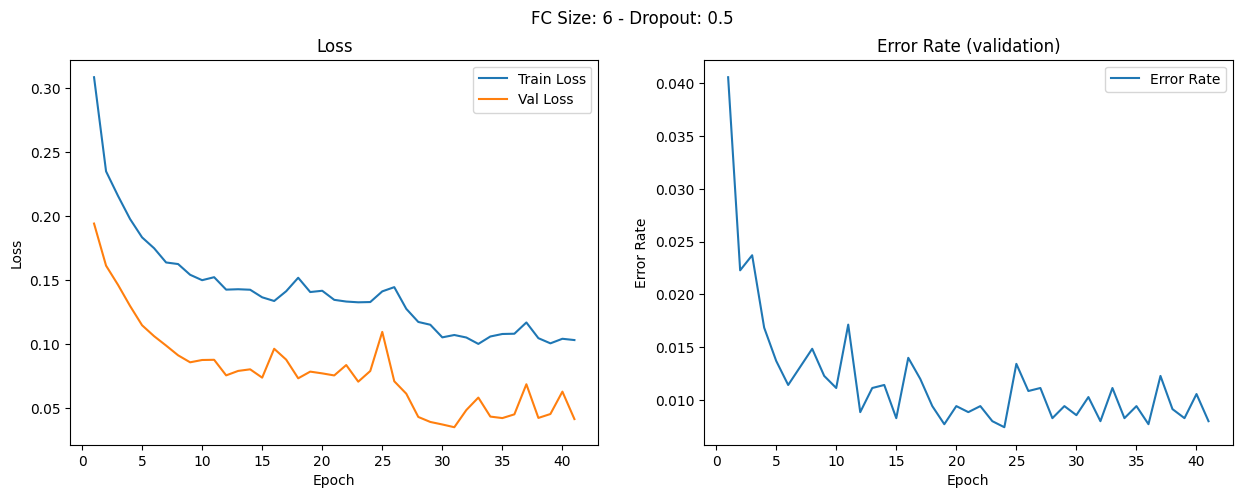

>>>>>>>>     FC Size: 12 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2083 - Val Loss: 0.1809 - Error Rate: 0.0660


Epoch 2/100	 Train Loss: 0.1010 - Val Loss: 0.0794 - Error Rate: 0.0286


Epoch 3/100	 Train Loss: 0.0793 - Val Loss: 0.0534 - Error Rate: 0.0174


Epoch 4/100	 Train Loss: 0.0637 - Val Loss: 0.0496 - Error Rate: 0.0157


Epoch 5/100	 Train Loss: 0.0523 - Val Loss: 0.0482 - Error Rate: 0.0174


Epoch 6/100	 Train Loss: 0.0468 - Val Loss: 0.0658 - Error Rate: 0.0260


Epoch 7/100	 Train Loss: 0.0339 - Val Loss: 0.0293 - Error Rate: 0.0109


Epoch 8/100	 Train Loss: 0.0292 - Val Loss: 0.0317 - Error Rate: 0.0094


Epoch 9/100	 Train Loss: 0.0224 - Val Loss: 0.0279 - Error Rate: 0.0083


Epoch 10/100	 Train Loss: 0.0201 - Val Loss: 0.0240 - Error Rate: 0.0077


Epoch 11/100	 Train Loss: 0.0093 - Val Loss: 0.0407 - Error Rate: 0.0126


Epoch 12/100	 Train Loss: 0.0107 - Val Loss: 0.0317 - Error Rate: 0.0091


Epoch 13/100	 Train Loss: 0.0125 - Val Loss: 0.0262 - Error Rate: 0.0080


Epoch 14/100	 Train Loss: 0.0073 - Val Loss: 0.0377 - Error Rate: 0.0109


Epoch 15/100	 Train Loss: 0.0066 - Val Loss: 0.0293 - Error Rate: 0.0074


Epoch 16/100	 Train Loss: 0.0050 - Val Loss: 0.0753 - Error Rate: 0.0183


Epoch 17/100	 Train Loss: 0.0076 - Val Loss: 0.0286 - Error Rate: 0.0077


Epoch 18/100	 Train Loss: 0.0028 - Val Loss: 0.0310 - Error Rate: 0.0069


Epoch 19/100	 Train Loss: 0.0006 - Val Loss: 0.0286 - Error Rate: 0.0069


Epoch 20/100	 Train Loss: 0.0037 - Val Loss: 0.0695 - Error Rate: 0.0183
Early stopping on epoch 20


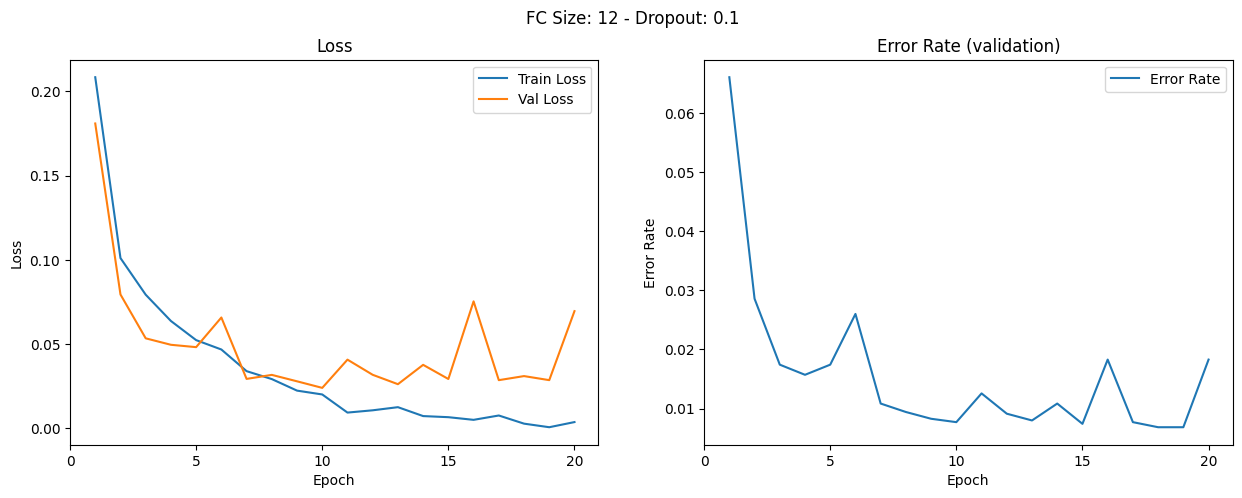

>>>>>>>>     FC Size: 12 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2194 - Val Loss: 0.0853 - Error Rate: 0.0237


Epoch 2/100	 Train Loss: 0.0888 - Val Loss: 0.0579 - Error Rate: 0.0183


Epoch 3/100	 Train Loss: 0.0626 - Val Loss: 0.0457 - Error Rate: 0.0134


Epoch 4/100	 Train Loss: 0.0522 - Val Loss: 0.0386 - Error Rate: 0.0126


Epoch 5/100	 Train Loss: 0.0418 - Val Loss: 0.0405 - Error Rate: 0.0134


Epoch 6/100	 Train Loss: 0.0316 - Val Loss: 0.0300 - Error Rate: 0.0103


Epoch 7/100	 Train Loss: 0.0219 - Val Loss: 0.0347 - Error Rate: 0.0097


Epoch 8/100	 Train Loss: 0.0245 - Val Loss: 0.0268 - Error Rate: 0.0089


Epoch 9/100	 Train Loss: 0.0235 - Val Loss: 0.0234 - Error Rate: 0.0080


Epoch 10/100	 Train Loss: 0.0152 - Val Loss: 0.0373 - Error Rate: 0.0114


Epoch 11/100	 Train Loss: 0.0200 - Val Loss: 0.0230 - Error Rate: 0.0066


Epoch 12/100	 Train Loss: 0.0103 - Val Loss: 0.0229 - Error Rate: 0.0063


Epoch 13/100	 Train Loss: 0.0082 - Val Loss: 0.0382 - Error Rate: 0.0097


Epoch 14/100	 Train Loss: 0.0056 - Val Loss: 0.0362 - Error Rate: 0.0094


Epoch 15/100	 Train Loss: 0.0066 - Val Loss: 0.0492 - Error Rate: 0.0114


Epoch 16/100	 Train Loss: 0.0081 - Val Loss: 0.0335 - Error Rate: 0.0089


Epoch 17/100	 Train Loss: 0.0138 - Val Loss: 0.0337 - Error Rate: 0.0103


Epoch 18/100	 Train Loss: 0.0050 - Val Loss: 0.0344 - Error Rate: 0.0091


Epoch 19/100	 Train Loss: 0.0049 - Val Loss: 0.0422 - Error Rate: 0.0091


Epoch 20/100	 Train Loss: 0.0097 - Val Loss: 0.0511 - Error Rate: 0.0114


Epoch 21/100	 Train Loss: 0.0081 - Val Loss: 0.0275 - Error Rate: 0.0069


Epoch 22/100	 Train Loss: 0.0052 - Val Loss: 0.0666 - Error Rate: 0.0200
Early stopping on epoch 22


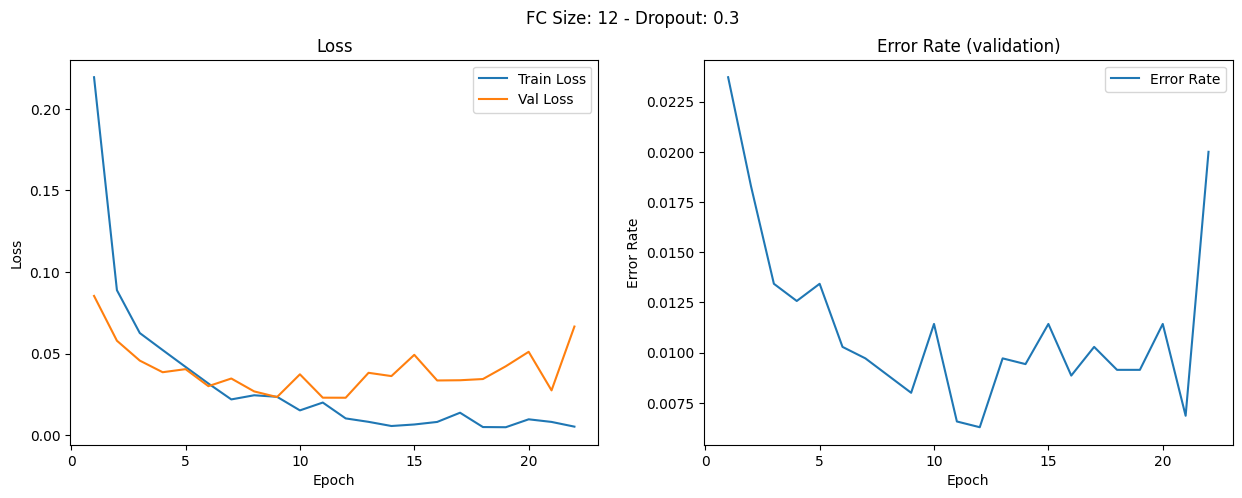

>>>>>>>>     FC Size: 12 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2780 - Val Loss: 0.1209 - Error Rate: 0.0480


Epoch 2/100	 Train Loss: 0.1673 - Val Loss: 0.0787 - Error Rate: 0.0291


Epoch 3/100	 Train Loss: 0.1336 - Val Loss: 0.0695 - Error Rate: 0.0249


Epoch 4/100	 Train Loss: 0.1188 - Val Loss: 0.0501 - Error Rate: 0.0134


Epoch 5/100	 Train Loss: 0.1052 - Val Loss: 0.0653 - Error Rate: 0.0343


Epoch 6/100	 Train Loss: 0.0996 - Val Loss: 0.0590 - Error Rate: 0.0183


Epoch 7/100	 Train Loss: 0.0895 - Val Loss: 0.0332 - Error Rate: 0.0100


Epoch 8/100	 Train Loss: 0.0884 - Val Loss: 0.0461 - Error Rate: 0.0154


Epoch 9/100	 Train Loss: 0.0835 - Val Loss: 0.0357 - Error Rate: 0.0103


Epoch 10/100	 Train Loss: 0.0823 - Val Loss: 0.0281 - Error Rate: 0.0080


Epoch 11/100	 Train Loss: 0.0695 - Val Loss: 0.0358 - Error Rate: 0.0117


Epoch 12/100	 Train Loss: 0.0716 - Val Loss: 0.0355 - Error Rate: 0.0163


Epoch 13/100	 Train Loss: 0.0669 - Val Loss: 0.0275 - Error Rate: 0.0091


Epoch 14/100	 Train Loss: 0.0668 - Val Loss: 0.0595 - Error Rate: 0.0160


Epoch 15/100	 Train Loss: 0.0680 - Val Loss: 0.0524 - Error Rate: 0.0134


Epoch 16/100	 Train Loss: 0.0611 - Val Loss: 0.0289 - Error Rate: 0.0080


Epoch 17/100	 Train Loss: 0.0612 - Val Loss: 0.0554 - Error Rate: 0.0171


Epoch 18/100	 Train Loss: 0.0631 - Val Loss: 0.0286 - Error Rate: 0.0094


Epoch 19/100	 Train Loss: 0.0526 - Val Loss: 0.0439 - Error Rate: 0.0103


Epoch 20/100	 Train Loss: 0.0674 - Val Loss: 0.0240 - Error Rate: 0.0080


Epoch 21/100	 Train Loss: 0.0590 - Val Loss: 0.0259 - Error Rate: 0.0091


Epoch 22/100	 Train Loss: 0.0539 - Val Loss: 0.0441 - Error Rate: 0.0109


Epoch 23/100	 Train Loss: 0.0540 - Val Loss: 0.0322 - Error Rate: 0.0117


Epoch 24/100	 Train Loss: 0.0516 - Val Loss: 0.0342 - Error Rate: 0.0069


Epoch 25/100	 Train Loss: 0.0576 - Val Loss: 0.0355 - Error Rate: 0.0086


Epoch 26/100	 Train Loss: 0.0576 - Val Loss: 0.1752 - Error Rate: 0.0311


Epoch 27/100	 Train Loss: 0.0566 - Val Loss: 0.0446 - Error Rate: 0.0094


Epoch 28/100	 Train Loss: 0.0532 - Val Loss: 0.0592 - Error Rate: 0.0109


Epoch 29/100	 Train Loss: 0.0620 - Val Loss: 0.0367 - Error Rate: 0.0094


Epoch 30/100	 Train Loss: 0.0498 - Val Loss: 0.0462 - Error Rate: 0.0129
Early stopping on epoch 30


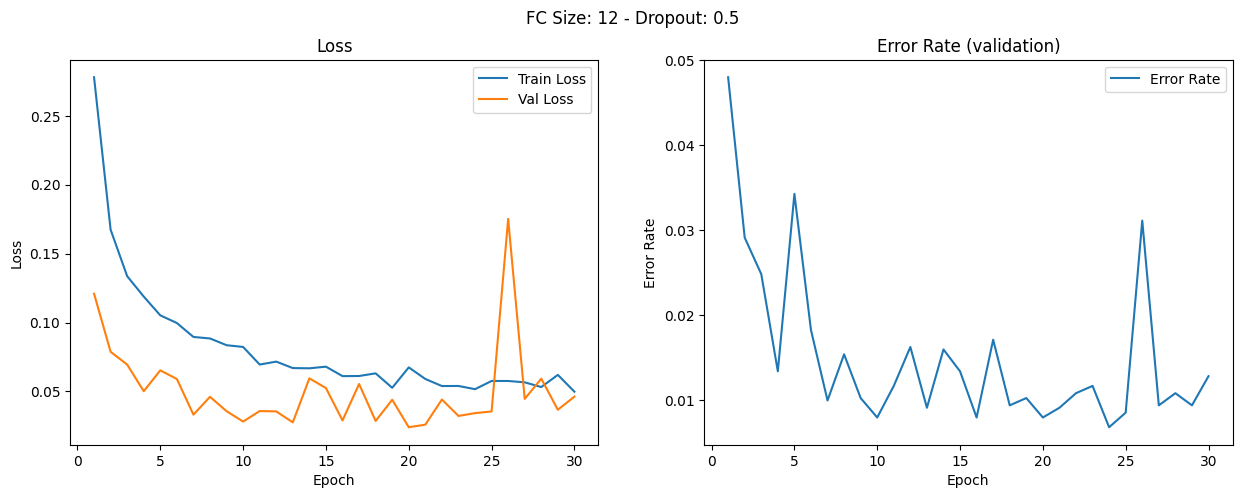

>>>>>>>>     FC Size: 24 - Dropout: 0.1     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2178 - Val Loss: 0.0862 - Error Rate: 0.0311


Epoch 2/100	 Train Loss: 0.0811 - Val Loss: 0.0963 - Error Rate: 0.0397


Epoch 3/100	 Train Loss: 0.0590 - Val Loss: 0.0721 - Error Rate: 0.0300


Epoch 4/100	 Train Loss: 0.0487 - Val Loss: 0.0960 - Error Rate: 0.0349


Epoch 5/100	 Train Loss: 0.0328 - Val Loss: 0.0281 - Error Rate: 0.0109


Epoch 6/100	 Train Loss: 0.0215 - Val Loss: 0.0316 - Error Rate: 0.0114


Epoch 7/100	 Train Loss: 0.0177 - Val Loss: 0.0323 - Error Rate: 0.0129


Epoch 8/100	 Train Loss: 0.0146 - Val Loss: 0.0300 - Error Rate: 0.0103


Epoch 9/100	 Train Loss: 0.0157 - Val Loss: 0.0400 - Error Rate: 0.0134


Epoch 10/100	 Train Loss: 0.0071 - Val Loss: 0.0239 - Error Rate: 0.0083


Epoch 11/100	 Train Loss: 0.0075 - Val Loss: 0.0441 - Error Rate: 0.0129


Epoch 12/100	 Train Loss: 0.0051 - Val Loss: 0.0347 - Error Rate: 0.0097


Epoch 13/100	 Train Loss: 0.0134 - Val Loss: 0.0534 - Error Rate: 0.0154


Epoch 14/100	 Train Loss: 0.0090 - Val Loss: 0.0301 - Error Rate: 0.0086


Epoch 15/100	 Train Loss: 0.0053 - Val Loss: 0.0241 - Error Rate: 0.0069


Epoch 16/100	 Train Loss: 0.0009 - Val Loss: 0.0302 - Error Rate: 0.0083


Epoch 17/100	 Train Loss: 0.0012 - Val Loss: 0.0433 - Error Rate: 0.0094


Epoch 18/100	 Train Loss: 0.0068 - Val Loss: 0.0388 - Error Rate: 0.0106


Epoch 19/100	 Train Loss: 0.0071 - Val Loss: 0.0454 - Error Rate: 0.0103


Epoch 20/100	 Train Loss: 0.0036 - Val Loss: 0.0303 - Error Rate: 0.0089


Epoch 21/100	 Train Loss: 0.0015 - Val Loss: 0.0322 - Error Rate: 0.0083
Early stopping on epoch 21


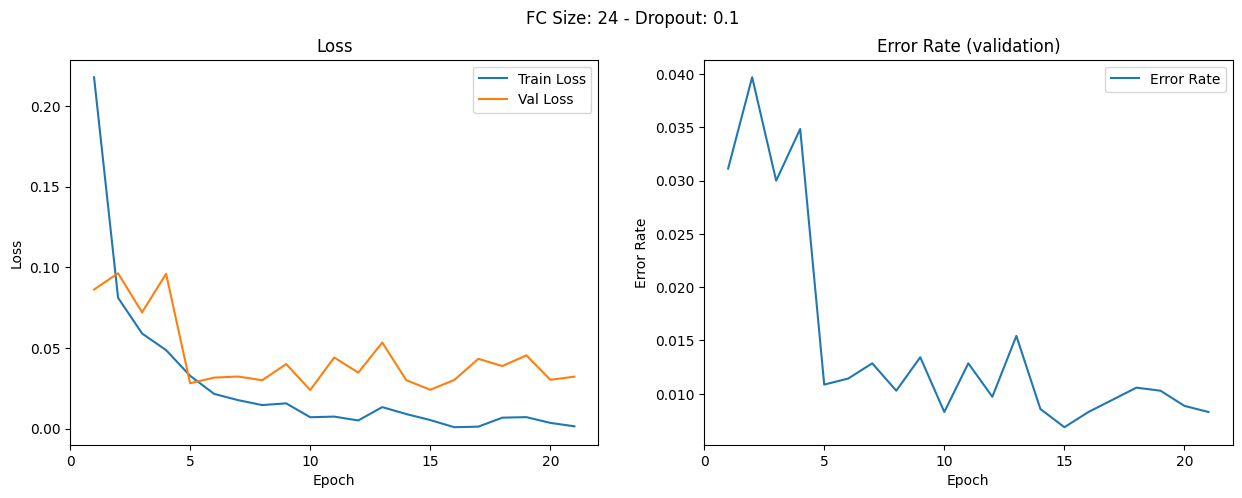

>>>>>>>>     FC Size: 24 - Dropout: 0.3     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2347 - Val Loss: 0.0963 - Error Rate: 0.0346


Epoch 2/100	 Train Loss: 0.1072 - Val Loss: 0.0731 - Error Rate: 0.0251


Epoch 3/100	 Train Loss: 0.0803 - Val Loss: 0.0500 - Error Rate: 0.0169


Epoch 4/100	 Train Loss: 0.0624 - Val Loss: 0.0378 - Error Rate: 0.0137


Epoch 5/100	 Train Loss: 0.0465 - Val Loss: 0.0365 - Error Rate: 0.0140


Epoch 6/100	 Train Loss: 0.0364 - Val Loss: 0.0294 - Error Rate: 0.0111


Epoch 7/100	 Train Loss: 0.0290 - Val Loss: 0.0411 - Error Rate: 0.0149


Epoch 8/100	 Train Loss: 0.0245 - Val Loss: 0.0301 - Error Rate: 0.0097


Epoch 9/100	 Train Loss: 0.0203 - Val Loss: 0.0290 - Error Rate: 0.0100


Epoch 10/100	 Train Loss: 0.0175 - Val Loss: 0.0322 - Error Rate: 0.0100


Epoch 11/100	 Train Loss: 0.0144 - Val Loss: 0.0297 - Error Rate: 0.0100


Epoch 12/100	 Train Loss: 0.0104 - Val Loss: 0.0303 - Error Rate: 0.0094


Epoch 13/100	 Train Loss: 0.0080 - Val Loss: 0.0359 - Error Rate: 0.0109


Epoch 14/100	 Train Loss: 0.0072 - Val Loss: 0.0333 - Error Rate: 0.0094


Epoch 15/100	 Train Loss: 0.0170 - Val Loss: 0.0291 - Error Rate: 0.0111


Epoch 16/100	 Train Loss: 0.0086 - Val Loss: 0.0358 - Error Rate: 0.0091


Epoch 17/100	 Train Loss: 0.0039 - Val Loss: 0.0361 - Error Rate: 0.0097


Epoch 18/100	 Train Loss: 0.0130 - Val Loss: 0.0265 - Error Rate: 0.0077


Epoch 19/100	 Train Loss: 0.0020 - Val Loss: 0.0378 - Error Rate: 0.0086


Epoch 20/100	 Train Loss: 0.0109 - Val Loss: 0.0351 - Error Rate: 0.0103


Epoch 21/100	 Train Loss: 0.0048 - Val Loss: 0.0377 - Error Rate: 0.0097


Epoch 22/100	 Train Loss: 0.0009 - Val Loss: 0.0479 - Error Rate: 0.0091


Epoch 23/100	 Train Loss: 0.0005 - Val Loss: 0.0505 - Error Rate: 0.0091


Epoch 24/100	 Train Loss: 0.0036 - Val Loss: 0.0670 - Error Rate: 0.0140


Epoch 25/100	 Train Loss: 0.0025 - Val Loss: 0.0609 - Error Rate: 0.0109


Epoch 26/100	 Train Loss: 0.0105 - Val Loss: 0.0468 - Error Rate: 0.0117


Epoch 27/100	 Train Loss: 0.0073 - Val Loss: 0.0522 - Error Rate: 0.0100


Epoch 28/100	 Train Loss: 0.0024 - Val Loss: 0.0479 - Error Rate: 0.0089
Early stopping on epoch 28


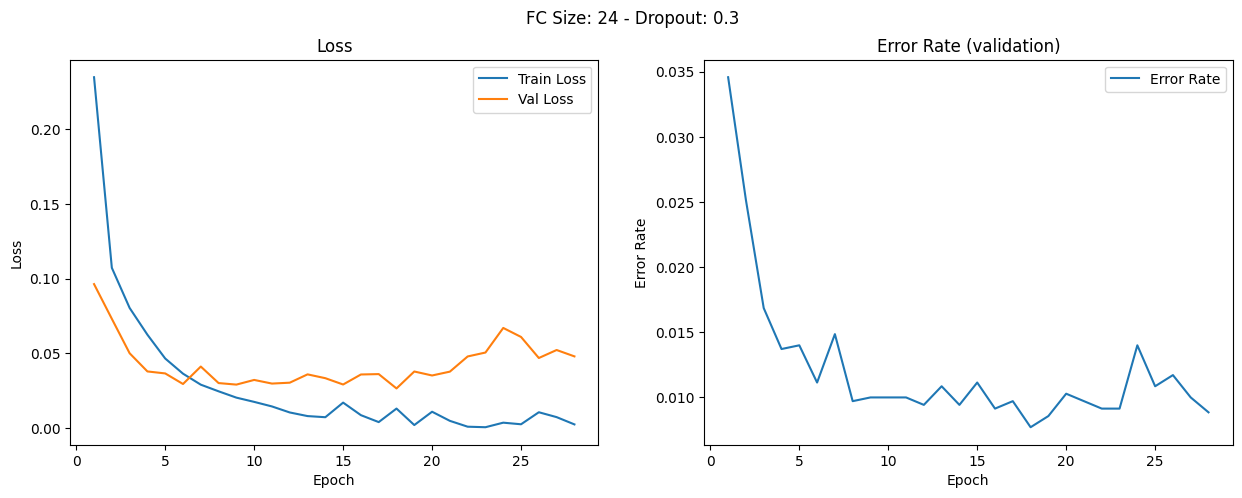

>>>>>>>>     FC Size: 24 - Dropout: 0.5     <<<<<<<<


Epoch 1/100	 Train Loss: 0.2255 - Val Loss: 0.0991 - Error Rate: 0.0320


Epoch 2/100	 Train Loss: 0.1058 - Val Loss: 0.0630 - Error Rate: 0.0229


Epoch 3/100	 Train Loss: 0.0786 - Val Loss: 0.0579 - Error Rate: 0.0209


Epoch 4/100	 Train Loss: 0.0672 - Val Loss: 0.0430 - Error Rate: 0.0129


Epoch 5/100	 Train Loss: 0.0535 - Val Loss: 0.0376 - Error Rate: 0.0120


Epoch 6/100	 Train Loss: 0.0418 - Val Loss: 0.0352 - Error Rate: 0.0111


Epoch 7/100	 Train Loss: 0.0371 - Val Loss: 0.0315 - Error Rate: 0.0114


Epoch 8/100	 Train Loss: 0.0240 - Val Loss: 0.0254 - Error Rate: 0.0094


Epoch 9/100	 Train Loss: 0.0267 - Val Loss: 0.0381 - Error Rate: 0.0126


Epoch 10/100	 Train Loss: 0.0232 - Val Loss: 0.0246 - Error Rate: 0.0086


Epoch 11/100	 Train Loss: 0.0196 - Val Loss: 0.0343 - Error Rate: 0.0109


Epoch 12/100	 Train Loss: 0.0175 - Val Loss: 0.0260 - Error Rate: 0.0074


Epoch 13/100	 Train Loss: 0.0092 - Val Loss: 0.0240 - Error Rate: 0.0080


Epoch 14/100	 Train Loss: 0.0135 - Val Loss: 0.0266 - Error Rate: 0.0080


Epoch 15/100	 Train Loss: 0.0062 - Val Loss: 0.0318 - Error Rate: 0.0074


Epoch 16/100	 Train Loss: 0.0132 - Val Loss: 0.0265 - Error Rate: 0.0074


Epoch 17/100	 Train Loss: 0.0126 - Val Loss: 0.0255 - Error Rate: 0.0077


Epoch 18/100	 Train Loss: 0.0068 - Val Loss: 0.0484 - Error Rate: 0.0109


Epoch 19/100	 Train Loss: 0.0151 - Val Loss: 0.0354 - Error Rate: 0.0066


Epoch 20/100	 Train Loss: 0.0057 - Val Loss: 0.0350 - Error Rate: 0.0071


Epoch 21/100	 Train Loss: 0.0031 - Val Loss: 0.0554 - Error Rate: 0.0097


Epoch 22/100	 Train Loss: 0.0081 - Val Loss: 0.0781 - Error Rate: 0.0131


Epoch 23/100	 Train Loss: 0.0155 - Val Loss: 0.0265 - Error Rate: 0.0060
Early stopping on epoch 23


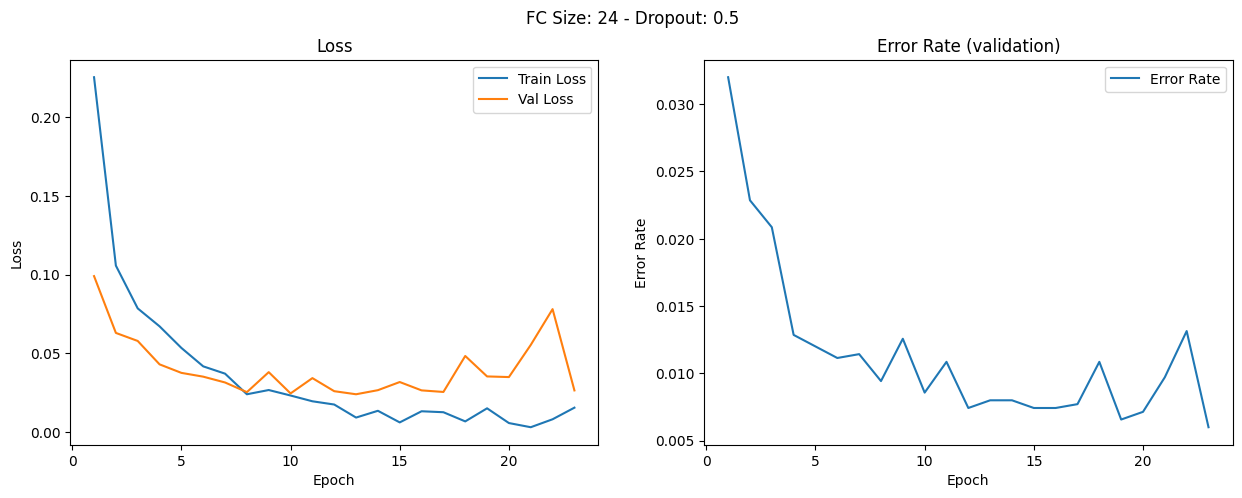

In [173]:
fc_sizes = [6, 12, 24]
dropouts = [0.1, 0.3, 0.5]
%matplotlib inline

for fc_size in fc_sizes:
    for dropout in dropouts:
        print(f'>>>>>>>>     FC Size: {fc_size} - Dropout: {dropout}     <<<<<<<<')
        # Create the model
        model = CustomConvNet(fc_size=fc_size, dropout=dropout).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

        # Create the dataloaders
        train_dataloader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_data, BATCH_SIZE, shuffle=False)

        train_losses = []
        val_losses = []
        err_rates = []
        early_stopper = EarlyStopper(patience=10, min_delta=5e-4)

        for epoch in range(EPOCHS):
            train_loss = train_model(train_dataloader, model, criterion, optimizer, checkpoint=(epoch+1)%5==0, desc=f'TrainingEpoch{(epoch + 1):02d}', dir_checkpoint=f'custom/fc_{fc_size}_dropout_{dropout}')
            val_loss, errors = evaluate(val_dataloader, model, criterion, desc=f'ValidationEpoch{(epoch + 1):02d}')
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            error_rate = (sum(errors) / len(val_data)).item()
            err_rates.append(error_rate)
            print(f'Epoch {epoch + 1}/{EPOCHS}\t Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Error Rate: {error_rate:.4f}')

            if early_stopper.early_stop(val_loss):
                print(f'Early stopping on epoch {epoch + 1}')
                break
        
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        fig.suptitle(f'FC Size: {fc_size} - Dropout: {dropout}')
        
        axs[0].title.set_text('Loss')
        axs[1].title.set_text('Error Rate (validation)')
        
        epochs = [i+1 for i in range(len(train_losses))]
        axs[0].plot(epochs, train_losses, label='Train Loss')
        axs[0].plot(epochs, val_losses, label='Val Loss')
        axs[1].plot(epochs, err_rates, label='Error Rate')
        
        epochs = [i for i in range(0, len(train_losses)+1, 5)]
        axs[0].set_xlabel('Epoch')
        axs[0].set_xticks(epochs)
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].set_xlabel('Epoch')
        axs[1].set_xticks(epochs)
        axs[1].set_ylabel('Error Rate')
        axs[1].legend()        

        plt.show()
        fig_dir = os.path.join(FIGURES_DIR, f'custom')
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
        fig_path = os.path.join(fig_dir, f'fc_{fc_size}_dropout_{dropout}.png')
        
        fig.savefig(fig_path)